In [1]:
%matplotlib notebook
from astropy.io import fits
from astropy.table import Table
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
psf_path = '/home/aalvarez/Work/Data/sim08/sex.out.psf'
sexx_out = '/home/aalvarez/Work/Projects/sextractorxx/tests/output.fits'

In [3]:
class PsfEx(object):
    def __init__(self, path):
        psfex_fits = fits.open(path)
        if 'PSF_DATA' not in psfex_fits:
            raise Exception('Missing PSF_DATA')
        self._from_hdu(psfex_fits['PSF_DATA'])
        
    def _from_hdu(self, psf_data):
        self._n_axis = psf_data.header['POLNAXIS']
        self._groups = list()
        self._names = list()
        self._offsets = list()
        self._scales = list()
        
        for i in range(1, self._n_axis + 1):
            self._groups.append(psf_data.header[f'POLGRP{i}'] - 1)
            self._names.append(psf_data.header[f'POLNAME{i}'])
            self._offsets.append(psf_data.header[f'POLZERO{i}'])
            self._scales.append(psf_data.header[f'POLSCAL{i}'])
            
        self._n_groups = psf_data.header['POLNGRP']
        self._degrees = list()
        for i in range(1, self._n_groups + 1):
            self._degrees.append(psf_data.header[f'POLDEG{i}'])
            
        self._width = psf_data.header['PSFAXIS1']
        self._height = psf_data.header['PSFAXIS2']
        self._n_coefs = psf_data.header['PSFAXIS3']
        
        if self._n_coefs > 1:
            self._powers = self._calculate_powers()
        
        self._coefs = np.array(psf_data.data[0][0], copy=True, dtype=np.float32)
            
    def _calculate_powers(self):
        exponents = np.zeros(self._n_axis, dtype=np.int)
        powers = np.zeros((self._n_coefs, self._n_axis), dtype=np.int)
        group_exponents = np.zeros(self._n_groups, dtype=np.int)
        group_exponents[:self._n_groups] = self._degrees
        
        # Constant
        powers[0,:] = 0
        if self._n_axis:
            group_exponents[self._groups[0]] -= 1
        
        # Polynom
        exponents[0] = 1
        pi = 1
        for t in reversed(range(1, self._n_coefs)):
            powers[pi,:] = exponents[:]
            pi += 1
            
            ei = 0
            for group in self._groups:
                if group_exponents[group]:
                    group_exponents[group] -= 1
                    exponents[ei] += 1
                    break
                else:
                    group_exponents[group] = exponents[ei]
                    exponents[ei] = 0
                    ei += 1
        
        return powers
    
    def get_size(self):
        return self._width, self._height
    
    def normalize_properties(self, *args):
        out = list()
        for i, a in enumerate(args):
            out.append((a - self._offsets[i]) / self._scales[i])
        return out
    
    def get_repr(self, i):
        if i == 0:
            return 'Constant'
        
        components = []
        for v, p in zip(self._names, self._powers[i,:]):
            if p != 0:
                components.append(f'{v}$^{p}$')
            
        return ' + '.join(components)
    
    def get_psf_scaled(self, *args):
        result = np.array(self._coefs[0], copy=True, dtype=np.float32)
        for i in range(1, self._n_coefs):
            exp = self._powers[i,:]
            coefs = self._coefs[i]
            acc = 1
            for v, e in zip(args, exp):
                acc *= v ** e
            result += coefs * acc
        return result
    
    def get_psf(self, *args):
        properties = self.normalize_properties(*args)
        return self.get_psf_scaled(*properties)

In [4]:
psfex = PsfEx(psf_path)
vars(psfex)

{'_coefs': array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ..., 
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],
 
        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ..., 
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],
 
        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ..., 
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]]], dtype=float32),
 '_degrees': [1],
 '_groups': [0, 0],
 '_height': 25,
 '_n_axis': 2,
 '_n_coefs': 3,
 '_n_gro

In [5]:
t = Table.read(sexx_out)

In [6]:
def get_entry(t, i):
    entry = t[i]
    psf = np.reshape(entry['psf'], (25, 25))
    # The catalog has a +1 to match FITS coordinates
    return (entry['pixel_centroid_x'] - 1, entry['pixel_centroid_y'] - 1), psf

In [7]:
def compare(i):
    coords, psf = get_entry(t, i)
    plt.figure(figsize=(8, 8))
    
    plt.subplot(2, 2, 1)
    plt.imshow(
        psf,
        cmap=plt.get_cmap('Greys_r'),
        norm=colors.LogNorm()
    )
    plt.title(f"{coords} {psf.dtype}")

    plt.subplot(2, 2, 2)
    rec = psfex.get_psf(*coords)
        
    plt.imshow(
        rec,
        cmap=plt.get_cmap('Greys_r'),
        norm=colors.LogNorm()
    )
    plt.title(psfex.normalize_properties(*coords))

    plt.subplot(2, 2, 3)
    plt.imshow(
        rec - psf,

    )
    plt.colorbar()

    plt.subplot(2, 2, 4)
    plt.imshow(
        np.isclose(psf, rec),
        norm=colors.Normalize(0, 1)
    )

    plt.tight_layout()

<IPython.core.display.Javascript object>


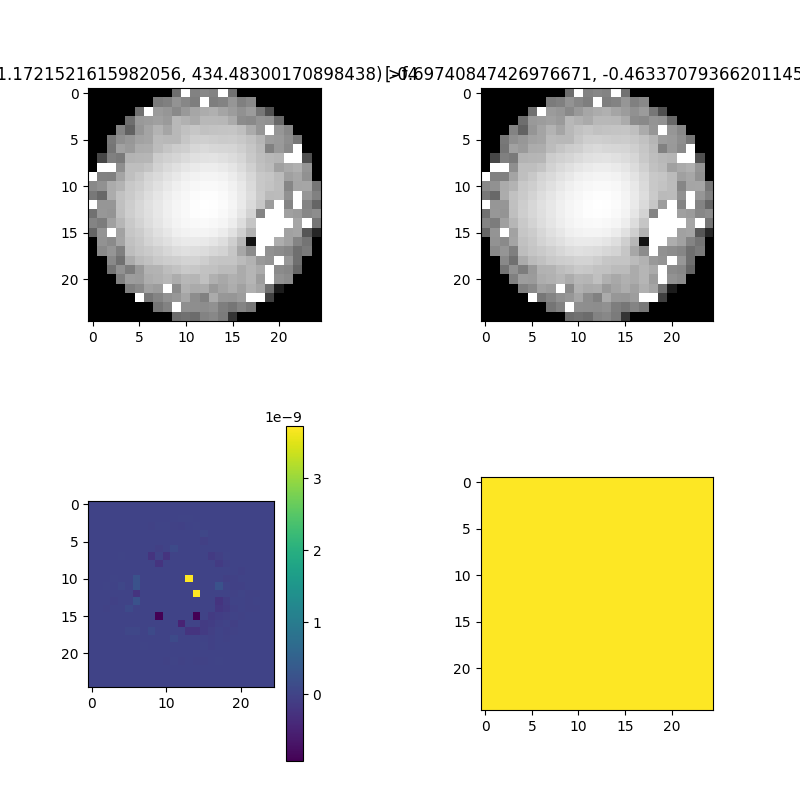

In [8]:
compare(600)

<IPython.core.display.Javascript object>


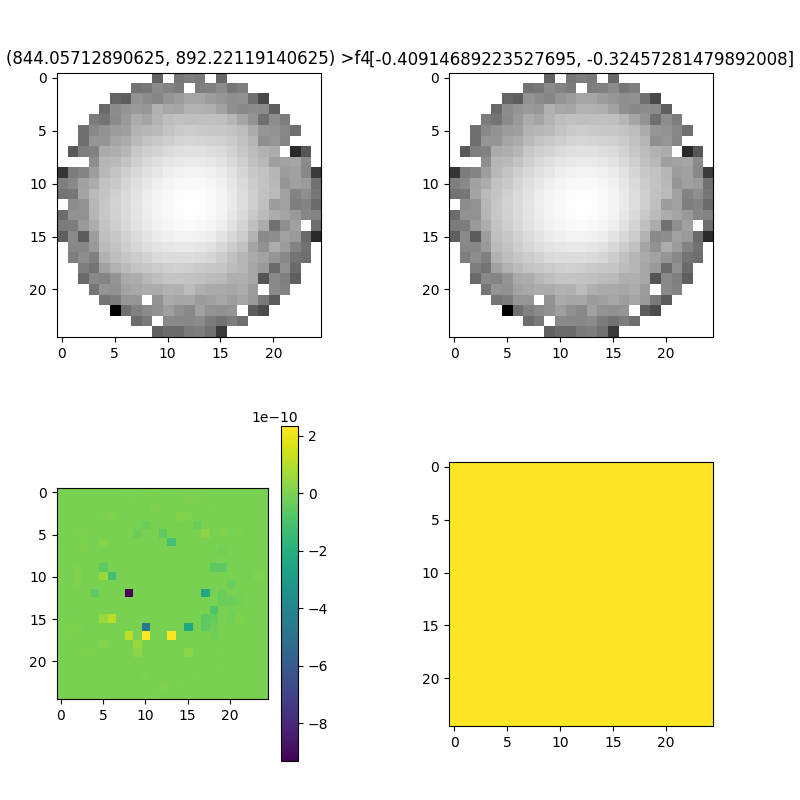

In [9]:
compare(1300)